In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# NLD Windfield generator program

In [2]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

## Calculate wind field using potential flow theory

### Set type of flow field
Options: ```circle``` and ```oval```

In [3]:
flow_type = 'circle' # Defines if hill is cylindrical or oval, options: 'oval' and 'circle'

### Set wind speed of flow field (in m/s):

In [4]:
U_inf = 10.0 # [m/s] Mean wind speed (negative to have flow flow right to left)

### Set hill parameters
* R_ridge: Radius of hill (in meters)
* surf_rough: surface roughness of hill (in meters)

Parameters only for oval shaped hill:
* a: defines loci x-position (in meters)
* x_stag: defines a-axis of standard oval (in meters)

In [5]:
R_ridge = 50.0 # [m] Radius of the hill/ridge
surf_rough = 0.01 # m, surface roughness

# Oval shaped hill parameters
a = 45 # m, defines loci x-position
x_stag = 67 # m, defines a-axis of standard oval
b = np.sqrt(x_stag**2 - a**2) # calculates b parameter of oval

### Potential flow field calculation function
Given an x and z coordinate and the mean wind speed it calculates the wind field velocity components using potential flow theory and a logarithmic boundary layer

#### Oval hill potential flow equations:

Source: 2.25 Advanced Fluid Mechanics MIT Department of Mechanical engineering (https://ocw.mit.edu/courses/mechanical-engineering/2-25-advanced-fluid-mechanics-fall-2013/potential-flow-theory/MIT2_25F13_Solution6.4.pdf)

$ x^2 - a^2 - \frac{m a}{\pi U_{\infty}} = 0$ <=>  $ m = \frac{\pi U_{\infty}}{a} (x^2 - a^2)$



$v_x = U_{\infty} + \frac{m}{2 \pi} \left[\frac{x + a}{(x + a)^2 + y^2} - \frac{x - a}{(x - a)^2 + y^2}\right]$

$v_y = \frac{m y}{2 \pi} \left[\frac{1}{(x+a)^2 + y^2} - \frac{1}{(x - a)^2 + y^2} \right]$

#### Circular hill potential flow equations:
Source: http://brennen.caltech.edu/fluidbook/basicfluiddynamics/potentialflow/singularities/cylinder.pdf

$u_r = \left[1 - \frac{R^2}{r^2}\right] U_{\infty} \cos{\theta}$

$u_{\theta} = -\left[1 + \frac{R^2}{r^2}\right] U_{\infty} \sin{\theta}$

Transform polar velocities into cartesian velocities:

$u_x = \cos{\theta} \cdot u_r - \sin{\theta} \cdot u_{\theta}$

$u_z = \sin{\theta} \cdot u_r + \cos{\theta} \cdot u_{\theta}$

#### Boundary layer wall function:
Source: https://en.wikipedia.org/wiki/Log_wind_profile#cite_note-Holmes2015-2

 $u({{z}_{2}})=u({{z}_{1}}){\frac {\ln \left(({{z}_{2}}-d)/{{z}_{0}}\right)}{\ln \left(({{z}_{1}}-d)/{{z}_{0}}\right)}}$

In [6]:
def wind_comp(x_i, z_i, U):
    ## Wind field calculation function

    # Description: Given an x and z coordinate and the mean wind speed it calculates the wind field velocity components
    #              using potential flow theory and a logarithmic boundary layer

    if flow_type == 'oval':

        m = np.pi * U_inf / a * (x_stag ** 2 - a **2)
        v_x = U_inf + m / (2 * np.pi) * ((x_i + a) / ((x_i+0.001 + a) ** 2 + z_i ** 2) - (x_i+0.001 - a) / ((x_i+0.001 - a)**2 + z_i**2))
        v_z = -(m * z_i) / (2 * np.pi) * (1 / ((x_i+0.001 + a)**2 + z_i**2) - 1 / ((x_i+0.001 - a)**2 + z_i**2))

        ellipse_eq = (x_i ** 2) / (x_stag ** 2) + (z_i ** 2) / (b ** 2)
        if ellipse_eq < 1:
            return 0.0, 0.0

        if x_i < x_stag:

            z_ellipse = -b / x_stag * np.sqrt(x_stag ** 2 - x_i ** 2)

            mult_factor = (np.log(-(z_i - z_ellipse) / surf_rough)) / (np.log(-(-70 - z_ellipse) / surf_rough))
            if mult_factor < 0:
                print("z_ab =", -(z_i - z_ellipse), "mult =", mult_factor)
            if not (np.isnan(mult_factor)):
                v_x *= mult_factor
                v_z *= mult_factor

        else:
            if z_i < 0:
                z_ellipse = -0.01
                mult_factor = (np.log(-(z_i - z_ellipse) / surf_rough)) / (np.log(-(-70 - z_ellipse) / surf_rough))
                v_x *= mult_factor
                v_z *= mult_factor
            else:
                return 0.0, 0.0
        return v_x, v_z

    elif flow_type == 'circle':
        theta = np.arctan2(-z_i, x_i)
        r = np.sqrt(x_i**2 + z_i**2)

        global R_ridge
        u_r = (1-((R_ridge**2)/(r**2)))*U*np.cos(theta)
        u_th = -(1+((R_ridge**2)/(r**2)))*U*np.sin(theta)

        if R_ridge**2 - x_i**2 > 0:
            z_circle = -np.sqrt(R_ridge**2 - x_i**2)

        else:
            z_circle = -0.01
        mult_factor = (np.log(-(z_i - z_circle) / surf_rough)) / (np.log(-(-70 - z_circle) / surf_rough))
        u_x = (np.cos(theta)*u_r - np.sin(theta)*u_th)*mult_factor
        u_z = (np.sin(theta)*u_r + np.cos(theta)*u_th)*mult_factor


        if r<R_ridge:
            return 0.0,0.0

        return u_x, u_z

In [7]:
vwind_comp = np.vectorize(wind_comp) # Vectorizes the wind comp function so arrays can be parsed and returned by the new
                                     # vwind_comp function

## Set 2D grid parameters

* dx = Grid resolution in x axix
* dz = Grid resolution in z axis
* x_coords = Array of x coordinates
* z_coords = Array of z coordinates

In [8]:
## Specify 2D grid resolution [in meters]
dx = 1.5
dz = -(4.0/3.0)
## ======================================

## Specify start and stop x & z coordinates:
x_start = -100
x_stop = 10

z_start = 0
z_stop = -R_ridge-20+dz+0.1
## ==========================================

## Create x and z coordinate array
x_coords = np.arange(x_start, x_stop, dx) # specifies range of x coords
z_coords = np.arange(z_start, z_stop, dz)  # specifies range of z coords
## ======================================

In [9]:
xs, zs = np.meshgrid(x_coords, z_coords) # create meshgrid to construct wind velocity field

Winds_u, Winds_v = vwind_comp(xs, zs, U_inf) # generates 2D matrices with horizontal and vertical wind velocity components

Total_wind = np.sqrt(np.power(Winds_u, 2) + np.power(Winds_v, 2)) # generates 2D matrix with total wind velocities

<ipython-input-6-e8174286490e>:51: RuntimeWarning: invalid value encountered in log
  mult_factor = (np.log(-(z_i - z_circle) / surf_rough)) / (np.log(-(-70 - z_circle) / surf_rough))


## Calculate hill contours

* xs_hill = x coordinates hill
* zs_hill = z coordinates hill

In [10]:
if flow_type == 'circle':
    # generates cartesian coordinates where edge of hill is present (for circular shaped hill)
    thetas = np.arange(0, np.pi, 0.01)
    xs_hill = R_ridge*np.cos(thetas)
    zs_hill = -R_ridge*np.sin(thetas)
else:
    # generates cartesian coordinates where edge of hill is present (for oval shaped hill)
    ts = np.arange(0, np.pi, 0.01)
    u = np.tan(ts / 2)
    xs_hill = x_stag * (1 - u ** 2) / (u ** 2 + 1)
    zs_hill = -(2 * b * u) / (u ** 2 + 1)

## Plot windfield with hill contour:

Text(0, 0.5, 'z location [m]')

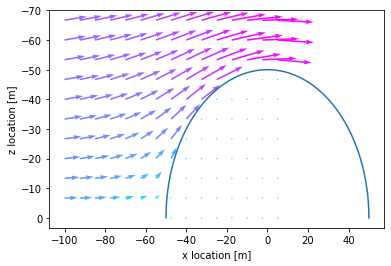

In [23]:
fig, ax = plt.subplots(1,1) # initialize pyplot figure (1 row, 1 column)
ax.invert_yaxis()
skip=(slice(None,None,5),slice(None,None,5))
ax.plot(xs_hill, zs_hill)
qv1 = ax.quiver(xs[skip], zs[skip], Winds_u[skip], Winds_v[skip], Total_wind[skip], cmap='cool') # plots vector field
ax.set_xlabel('x location [m]')
ax.set_ylabel('z location [m]')

## Set UAV Parameters

In [13]:
m = 1.0 # mass, in kg

S = 1 # Wing surface area, in m^2
rho = 1.225 # Air density, in kg/m^3
g = 9.80665 # gtavitational acceleration, in m/s^2
CL_alpha = 5.7 # Lift coefficient slope, in 1/rad
alpha_0L = np.deg2rad(-4) # Zero lift angle of attack, in degrees
AR = 6 # Aspect ratio
e = 0.8 # Oswald efficiency factor
CD_0 = 0.05 # Zero-lift drag coefficient

# Specific turbine disc area: S_turb_spec = S_turb_disc / S
S_turb_spec = 0.1 # 0.006 for smallest point at gridsize of 0.1

W = m*g

Cdi_coef = 1/(np.pi*AR*e) # 1/pi*A*e

#P_maxs = (16/27)*(rho/2)* Total_wind**3 * (np.pi*D_prop**2)/4



## Parameters for numerical integration
V_a = 25 # initial airspeed for simulated aircraft m/s
gamma_a = -10*(np.pi/180) # deg/rad
dgamma_dt = 0 # rad/s
dt = 0.01 # s
t = 0 #s
x_i = 17
z_i = -5



## Equilibrium calculation function

This function determines if the UAV is theoratically able to statically hover with zero ground speed at each point of the calculated wind field. At each potential hover location, the required additional drag and power needed from the turbine is calculated as well as the angle of attack. 

$C_{L_{req}} = \frac{W}{0.5 \cdot \rho \cdot V^2 \cdot S} \cdot \frac{u}{V}$

$C_{D_{req}} = \frac{W}{0.5 \cdot \rho \cdot V^2 \cdot S} \cdot \frac{v}{V}$

$C_{D_{min}} = C_{D_0} + \frac{C_L^2}{\pi A e}$

$C_{D_{max}} = C_{D_{min}} + \frac{2}{9} \cdot S_{turb}$

$



In [14]:
def calc_eq():
    # This function calculates the 
    C_L_req = W/(0.5*rho*np.power(Total_wind, 2)*S) * (np.abs(Winds_u)/Total_wind)
    C_D_req = W / (0.5 * rho * np.power(Total_wind, 2) * S) * (np.abs(Winds_v) / Total_wind)

    #drag_turb_func = get_turbine_params()

    C_D_min_ach = CD_0+np.power(C_L_req, 2)*Cdi_coef
    C_D_max_ach = C_D_min_ach + 1*(2/9)*S_turb_spec#drag_turb_func(Total_wind)/(0.5* rho * np.power(Total_wind, 2) * S)#1*(2/9)*S_turb_spec

    C_D_turb = C_D_req - C_D_min_ach

    D_turb = 0.5*rho*np.power(Total_wind, 2)*S*C_D_turb

    alpha = C_L_req / CL_alpha + alpha_0L

    stall = (alpha > np.deg2rad(15)) & (alpha < np.deg2rad(-10))
    print("stall condition:", stall[stall == True])
    C_L_req[stall] = np.nan
    C_D_req[stall] = np.nan
    C_D_min_ach[stall] = np.nan
    C_D_max_ach[stall] = np.nan
    alpha[stall] = np.nan

    eq_points = (C_D_req > C_D_min_ach) & (C_D_req < C_D_max_ach)
    P_turb = 0.5*rho*S*np.power(Total_wind, 3)*C_D_turb
    P_turb[eq_points == False] = np.nan
    alpha[eq_points == False] = np.nan
    D_turb[eq_points == False] = np.nan
    return P_turb, np.rad2deg(alpha), D_turb

In [15]:
def get_local_min_h_dot(V_loc):
    min_h_dot = (rho * S * CD_0) / (2 * m * g) * V_loc ** 3 + (2 * m * g * Cdi_coef) / (rho * S * V_loc)
    return min_h_dot

### Calculate equilibrium positions from windfield

In [16]:
P_turbs, alphas_eq, D_turb = calc_eq()

stall condition: []


<ipython-input-14-42827188c161>:3: RuntimeWarning: divide by zero encountered in true_divide
  C_L_req = W/(0.5*rho*np.power(Total_wind, 2)*S) * (np.abs(Winds_u)/Total_wind)
<ipython-input-14-42827188c161>:3: RuntimeWarning: invalid value encountered in true_divide
  C_L_req = W/(0.5*rho*np.power(Total_wind, 2)*S) * (np.abs(Winds_u)/Total_wind)
<ipython-input-14-42827188c161>:4: RuntimeWarning: divide by zero encountered in true_divide
  C_D_req = W / (0.5 * rho * np.power(Total_wind, 2) * S) * (np.abs(Winds_v) / Total_wind)
<ipython-input-14-42827188c161>:4: RuntimeWarning: invalid value encountered in true_divide
  C_D_req = W / (0.5 * rho * np.power(Total_wind, 2) * S) * (np.abs(Winds_v) / Total_wind)
<ipython-input-14-42827188c161>:17: RuntimeWarning: invalid value encountered in greater
  stall = (alpha > np.deg2rad(15)) & (alpha < np.deg2rad(-10))
<ipython-input-14-42827188c161>:17: RuntimeWarning: invalid value encountered in less
  stall = (alpha > np.deg2rad(15)) & (alpha < np

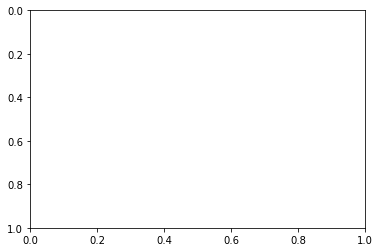

In [18]:
P_turbs = np.ma.masked_where(Winds_v <= get_local_min_h_dot(Total_wind), P_turbs) # changed to P_maxs
P_turb_max = np.nanmax(P_turbs)
print("max P_turb:", P_turb_max)
#5 * round(P_turb_max/5)+0.1
D_turbs = np.ma.masked_where(Winds_v <= get_local_min_h_dot(Total_wind), D_turb)
print(P_turbs)

max P_turb: 18.949256864514787
[[nan nan nan ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


<ipython-input-15-fc4af3330426>:2: RuntimeWarning: divide by zero encountered in true_divide
  min_h_dot = (rho * S * CD_0) / (2 * m * g) * V_loc ** 3 + (2 * m * g * Cdi_coef) / (rho * S * V_loc)
<ipython-input-18-37da7d75e652>:1: RuntimeWarning: invalid value encountered in less_equal
  P_turbs = np.ma.masked_where(Winds_v <= get_local_min_h_dot(Total_wind), P_turbs) # changed to P_maxs
<ipython-input-18-37da7d75e652>:5: RuntimeWarning: invalid value encountered in less_equal
  D_turbs = np.ma.masked_where(Winds_v <= get_local_min_h_dot(Total_wind), D_turb)


Text(0, 0.5, 'z location [m]')

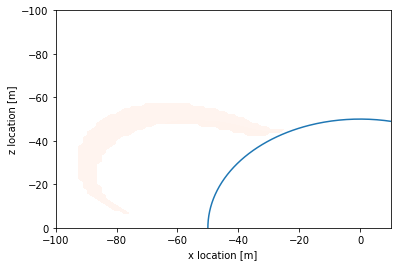

In [25]:
fig2, ax2 = plt.subplots(1,1) # initialize pyplot figure (1 row, 1 column)
ax2.invert_yaxis()
ax2.set_xlim([-100, 10])
ax2.set_ylim([0,-100])
colormap_levels = np.arange(0, 1000, 10)
ax2.plot(xs_hill, zs_hill)
cp = ax2.contourf(xs, zs, P_turbs, colormap_levels, cmap='Reds')#locator=ticker.LogLocator(subs=0.5), cmap='Reds')
ax2.set_xlabel('x location [m]')
ax2.set_ylabel('z location [m]')